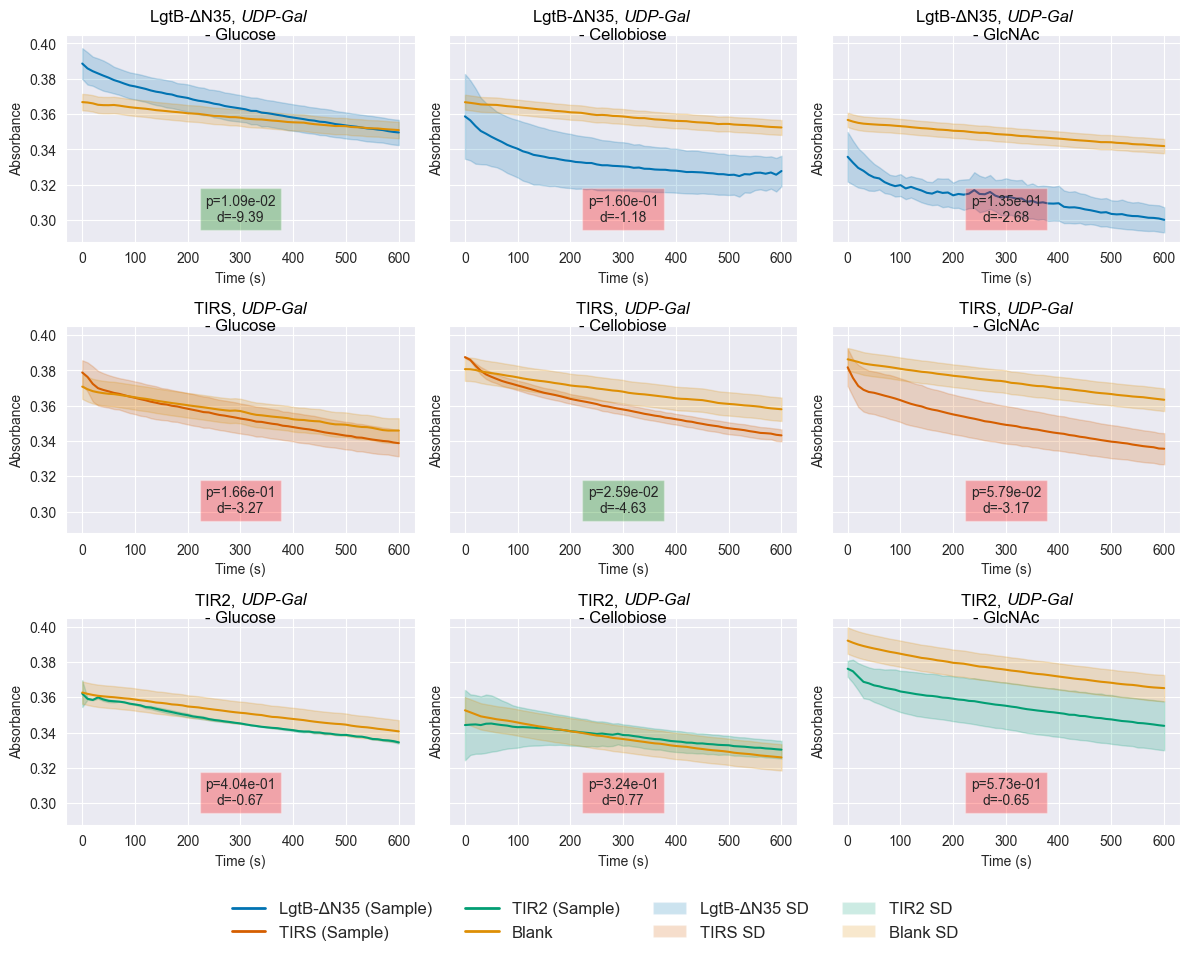

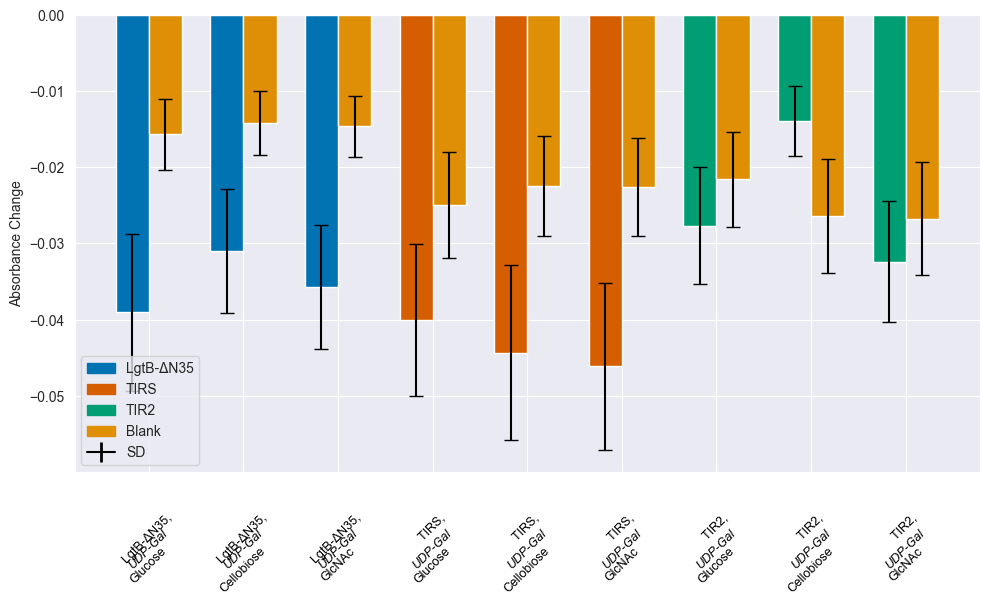

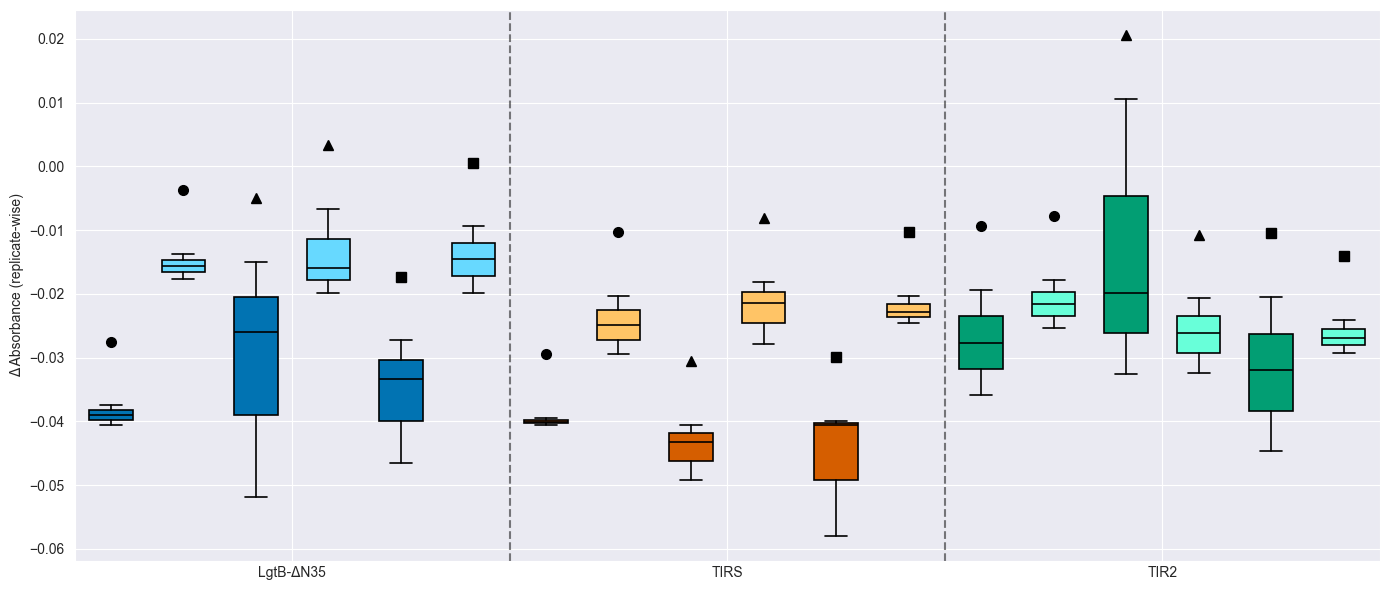

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_rel
from scipy.interpolate import interp1d

# Load the Excel file
file_path = r'C:\Users\Lenovo\Documents\BT Studies\MASTER PROJECT\Tecans_pHassay.xlsx'
xls = pd.ExcelFile(file_path)

# Use Seaborn colorblind palette
palette = sns.color_palette("colorblind", 10)
enzyme_color_map = {
    "LgtB-ΔN35": palette[0],   # blue
    "TIRS": palette[3],   # red
    "TIR2": palette[2]    # green
}
blank_color = palette[1]  # orange

# Define enzyme row indices
enzyme_rows = {
    "LgtB-ΔN35, UDP-Gal": (1, 13),
    "TIRS, UDP-Gal": (15, 27),
    "TIR2, UDP-Gal": (29, 41)
}

# Extract data from sheets
data = {}
for sheet_name in ["Activity", "Blanks"]:
    df = xls.parse(sheet_name, header=None)
    sheet_data = {}
    for enzyme, (start, end) in enzyme_rows.items():
        enzyme_section = df.iloc[start:end]
        time_values = enzyme_section.iloc[1, 1:].astype(float).values
        temp_values = enzyme_section.iloc[2, 1:].astype(float).values
        temp_mean = np.mean(temp_values)

        substrates = {}
        i = 4
        while i < len(enzyme_section):
            if pd.notna(enzyme_section.iloc[i, 0]):
                substrate = enzyme_section.iloc[i, 0]
                values = []
                while i < len(enzyme_section) and enzyme_section.iloc[i, 0] == substrate:
                    values.append(enzyme_section.iloc[i, 1:].astype(float).values)
                    i += 1
                substrates[substrate] = np.asarray(values)
            else:
                i += 1

        sheet_data[enzyme] = {"time": time_values, "temp": temp_mean, "substrates": substrates}
    data[sheet_name] = sheet_data

# --- Time course plots ---
fig, axes = plt.subplots(len(enzyme_rows), 3, figsize=(12, 10), sharey=True)

for row_idx, enzyme in enumerate(enzyme_rows.keys()):
    enzyme_key = enzyme.split(',')[0]
    enzyme_color = enzyme_color_map.get(enzyme_key, 'blue')

    for col_idx, substrate in enumerate(["Glucose", "Cellobiose", "GlcNAc"]):
        ax = axes[row_idx, col_idx]

        activity = data["Activity"][enzyme]["substrates"][substrate]
        blanks = data["Blanks"][enzyme]["substrates"][substrate]
        activity_time = data["Activity"][enzyme]["time"]
        blanks_time = data["Blanks"][enzyme]["time"]

        interp_func = interp1d(blanks_time, blanks.mean(axis=0), kind='linear', fill_value='extrapolate')
        blanks_interp = interp_func(activity_time)

        # Compute replicate-wise deltas
        activity_deltas = activity[:, -1] - activity[:, 0]
        blank_deltas = blanks[:, -1] - blanks[:, 0]

        # Perform paired t-test
        p_value = ttest_rel(activity_deltas, blank_deltas).pvalue
        significant = p_value < 0.05

        # Compute Cohen’s d from replicate deltas
        mean_diff = np.mean(activity_deltas) - np.mean(blank_deltas)
        pooled_std = np.sqrt((np.std(activity_deltas, ddof=1)**2 + np.std(blank_deltas, ddof=1)**2) / 2)
        effect_size = mean_diff / pooled_std

        # Plot activity and blanks with SD
        ax.plot(activity_time, activity.mean(axis=0), color=enzyme_color)
        ax.plot(activity_time, blanks_interp, color=blank_color)
        ax.fill_between(activity_time, activity.mean(axis=0) - activity.std(axis=0),
                        activity.mean(axis=0) + activity.std(axis=0), color=enzyme_color, alpha=0.2)
        ax.fill_between(activity_time, blanks_interp - np.std(blanks_interp),
                        blanks_interp + np.std(blanks_interp), color=blank_color, alpha=0.2)

        # p-value box
        color = "green" if significant else "red"
        ax.text(0.5, 0.1, f"p={p_value:.2e}\nd={effect_size:.2f}",
                transform=ax.transAxes, fontsize=10, ha='center', bbox=dict(facecolor=color, alpha=0.3))

        # Title with italic UDP-Gal
        enzyme_parts = enzyme.split("UDP-Gal")
        title_x = 0.5
        title_y = 1.05
        ax.set_title("")
        ax.text(title_x, title_y, enzyme_parts[0], transform=ax.transAxes,
                ha='right', va='bottom', fontsize=12, color='black')
        ax.text(title_x, title_y, "UDP-Gal", transform=ax.transAxes,
                ha='left', va='bottom', fontsize=12, color='black', style='italic')
        ax.text(title_x, title_y - 0.07, f"- {substrate}", transform=ax.transAxes,
                ha='center', fontsize=12, color='black')

        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Absorbance")

# Add legend
legend_handles = [
    plt.Line2D([0], [0], color=palette[0], label='LgtB-ΔN35 (Sample)', linewidth=2),
    plt.Line2D([0], [0], color=palette[3], label='TIRS (Sample)', linewidth=2),
    plt.Line2D([0], [0], color=palette[2], label='TIR2 (Sample)', linewidth=2),
    plt.Line2D([0], [0], color=blank_color, label='Blank', linewidth=2),
    plt.Rectangle((0, 0), 1, 1, fc=palette[0], alpha=0.2, label='LgtB-ΔN35 SD'),
    plt.Rectangle((0, 0), 1, 1, fc=palette[3], alpha=0.2, label='TIRS SD'),
    plt.Rectangle((0, 0), 1, 1, fc=palette[2], alpha=0.2, label='TIR2 SD'),
    plt.Rectangle((0, 0), 1, 1, fc=blank_color, alpha=0.2, label='Blank SD')
]
fig.legend(handles=legend_handles, loc='lower center', ncol=4, fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0.07, 1, 0.96])
plt.show()

# --- Bar plot ---
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(bottom=0.28)

bar_width = 0.35
x_labels = []
activity_means = []
blanks_means = []
activity_stds = []
blanks_stds = []
bar_colors = []

for enzyme in enzyme_rows.keys():
    enzyme_key = enzyme.split(',')[0]
    enzyme_color = enzyme_color_map.get(enzyme_key, 'blue')

    for substrate in ["Glucose", "Cellobiose", "GlcNAc"]:
        activity = data["Activity"][enzyme]["substrates"][substrate]
        blanks = data["Blanks"][enzyme]["substrates"][substrate]

        activity_means.append(activity.mean(axis=0)[-1] - activity.mean(axis=0)[0])
        blanks_means.append(blanks.mean(axis=0)[-1] - blanks.mean(axis=0)[0])
        activity_stds.append(np.std(activity.mean(axis=0)))
        blanks_stds.append(np.std(blanks.mean(axis=0)))
        x_labels.append(f"{enzyme}\n{substrate}")
        bar_colors.append(enzyme_color)

x = np.arange(len(x_labels))
bars1 = ax.bar(x - bar_width/2, activity_means, bar_width, yerr=activity_stds,
               capsize=5, color=bar_colors, label="Sample")
bars2 = ax.bar(x + bar_width/2, blanks_means, bar_width, yerr=blanks_stds,
               capsize=5, color=blank_color, label="Blank")

# Custom tick labels with italic UDP-Glc
ax.set_xticks(x)
ax.set_xticklabels([""] * len(x))
for i, label in enumerate(x_labels):
    enzyme_name, substrate = label.split('\n')
    if "UDP-Gal" in enzyme_name:
        parts = enzyme_name.split("UDP-Gal")
        ax.text(x[i], -0.08, parts[0], ha='center', va='top', rotation=45, fontsize=9, color='black', transform=ax.get_xaxis_transform())
        ax.text(x[i], -0.12, "UDP-Gal", ha='center', va='top', rotation=45, fontsize=9, color='black', style='italic', transform=ax.get_xaxis_transform())
        ax.text(x[i], -0.16, substrate, ha='center', va='top', rotation=45, fontsize=9, color='black', transform=ax.get_xaxis_transform())
    else:
        ax.text(x[i], -0.11, f"{enzyme_name}\n{substrate}", ha='center', va='top', rotation=45, fontsize=9, color='black', transform=ax.get_xaxis_transform())

ax.set_ylabel("Absorbance Change")

from matplotlib.lines import Line2D

sd_dumbbell = Line2D(
  [1], [0], color='black', linewidth=1.5,  # Make the line appear on the far right
  marker='|', markersize=15, markeredgewidth=2,
  label='SD', linestyle='-'
)

# Color-coded bars and legend elements
bar_legend = [
    plt.Rectangle((0, 0), 1, 1, color=palette[0], label='LgtB-ΔN35'),
    plt.Rectangle((0, 0), 1, 1, color=palette[3], label='TIRS'),
    plt.Rectangle((0, 0), 1, 1, color=palette[2], label='TIR2'),
    plt.Rectangle((0, 0), 1, 1, color=blank_color, label='Blank'),
    sd_dumbbell
]

ax.legend(handles=bar_legend, loc='lower left', fontsize=10)

plt.tight_layout()
plt.show()

# --- Boxplot of replicate-wise deltas -----------------------------------------------------------
# --- Boxplot of replicate-wise deltas with clean layout ---
fig, ax = plt.subplots(figsize=(14, 6))

delta_data = []
box_colors = []
substrate_shapes = []
enzyme_boundaries = []
group_labels = []
positions = []

substrate_icons = {
    "Glucose": "o",      # circle
    "Cellobiose": "^",   # triangle
    "GlcNAc": "s"        # square
}

current_pos = 0
for enzyme in enzyme_rows.keys():
    enzyme_key = enzyme.split(',')[0]
    enzyme_color = enzyme_color_map.get(enzyme_key, 'blue')
    enzyme_start = current_pos

    for substrate in ["Glucose", "Cellobiose", "GlcNAc"]:
        activity = data["Activity"][enzyme]["substrates"][substrate]
        blanks = data["Blanks"][enzyme]["substrates"][substrate]

        activity_deltas = activity[:, -1] - activity[:, 0]
        blank_deltas = blanks[:, -1] - blanks[:, 0]

        # Sample
        delta_data.append(activity_deltas)
        positions.append(current_pos)
        box_colors.append(enzyme_color)
        substrate_shapes.append(substrate_icons[substrate])
        group_labels.append("")  # no text label
        current_pos += 1

        # Blank
        delta_data.append(blank_deltas)
        positions.append(current_pos)
        lighter_color = tuple(min(1, c + 0.4) for c in enzyme_color)
        box_colors.append(lighter_color)
        substrate_shapes.append(substrate_icons[substrate])
        group_labels.append("")
        current_pos += 1

    enzyme_boundaries.append((enzyme_key, enzyme_start, current_pos - 1))

# Draw boxplot manually to allow coloring
box = ax.boxplot(delta_data, positions=positions, patch_artist=True, widths=0.6)

for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.2)

for element in ['whiskers', 'caps', 'medians']:
    for line in box[element]:
        line.set_color('black')
        line.set_linewidth(1.2)

# Add icons above boxes
for idx, shape in enumerate(substrate_shapes):
    ymax = np.max(delta_data[idx])
    ax.plot(positions[idx], ymax + 0.01, shape, color='black', markersize=7)

# Add enzyme group labels below x-axis
xtick_positions = []
xtick_labels = []

for enzyme_name, start, end in enzyme_boundaries:
    mid = (start + end) / 2
    xtick_positions.append(mid)
    xtick_labels.append(enzyme_name)

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, fontsize=10)
ax.tick_params(axis='x', length=0)  # remove x-axis tick lines

# Dashed lines to separate enzyme groups
group_boundaries = [end + 1 for _, _, end in enzyme_boundaries[:-1]]
for boundary in group_boundaries:
    ax.axvline(x=boundary - 0.5, color='black', linestyle='--', alpha=0.5)

# Axis styling
ax.set_ylabel("Δ Absorbance (replicate-wise)")
ax.set_xlim(-0.5, current_pos - 0.5)
ax.set_xlabel("")  # no x-axis label
ax.set_title("")   # no plot title
plt.tight_layout()
plt.show()




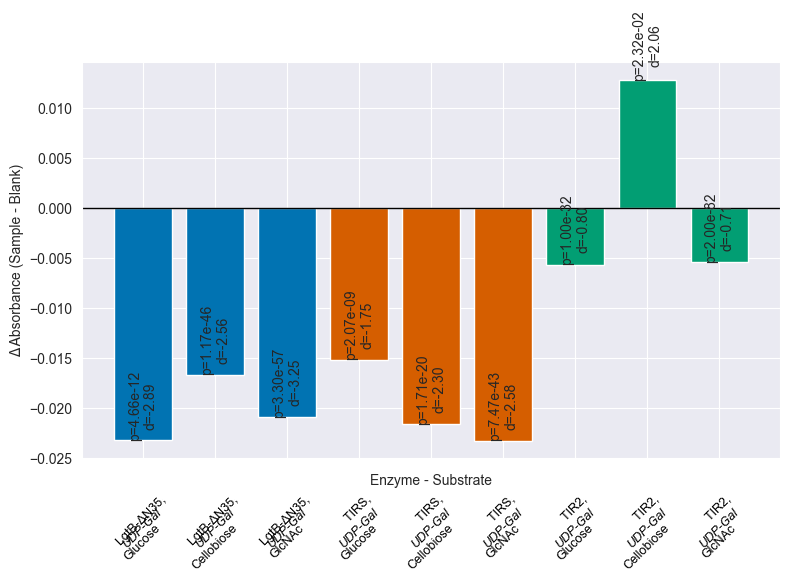

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_rel
from scipy.interpolate import interp1d

# Load the Excel file
file_path = r'C:\Users\Lenovo\Documents\BT Studies\MASTER PROJECT\Tecans_pHassay.xlsx'
xls = pd.ExcelFile(file_path)

# Use Seaborn colorblind palette
palette = sns.color_palette("colorblind", 10)

# Define enzyme row indices
enzyme_rows = {
    "LgtB-ΔN35, UDP-Gal": (1, 13),
    "TIRS, UDP-Gal": (15, 27),
    "TIR2, UDP-Gal": (29, 41)
}

# Extract data from sheets
data = {}
for sheet_name in ["Activity", "Blanks"]:
    df = xls.parse(sheet_name, header=None)
    sheet_data = {}
    for enzyme, (start, end) in enzyme_rows.items():
        enzyme_section = df.iloc[start:end]
        time_values = enzyme_section.iloc[1, 1:].astype(float).values  # Time row
        temp_values = enzyme_section.iloc[2, 1:].astype(float).values  # Temperature row
        temp_mean = np.mean(temp_values)  # Compute mean temperature

        substrates = {}
        i = 4
        while i < len(enzyme_section):
            if pd.notna(enzyme_section.iloc[i, 0]):
                substrate = enzyme_section.iloc[i, 0]
                values = []
                while i < len(enzyme_section) and enzyme_section.iloc[i, 0] == substrate:
                    values.append(enzyme_section.iloc[i, 1:].astype(float).values)
                    i += 1

                substrates[substrate] = np.asarray(values)
            else:
                i += 1

        sheet_data[enzyme] = {"time": time_values, "temp": temp_mean, "substrates": substrates}

    data[sheet_name] = sheet_data

# Color mapping for enzymes from the colorblind palette
enzyme_colors = {
    "LgtB-ΔN35, UDP-Gal": palette[0],  # First color in the palette
    "TIRS, UDP-Gal": palette[3],  # Second color in the palette
    "TIR2, UDP-Gal": palette[2]   # Third color in the palette
}

# Statistical comparison and visualization
plt.figure(figsize=(8, 6))
for enzyme in enzyme_rows.keys():
    for substrate in ["Glucose", "Cellobiose", "GlcNAc"]:
        activity = data["Activity"][enzyme]["substrates"][substrate]
        blanks = data["Blanks"][enzyme]["substrates"][substrate]

        activity_time = data["Activity"][enzyme]["time"]
        blanks_time = data["Blanks"][enzyme]["time"]

        # Interpolate blanks data to match activity time points
        interp_func = interp1d(blanks_time, blanks.mean(axis=0), kind='linear', fill_value='extrapolate')
        blanks_interp = interp_func(activity_time)

        # Calculate mean start and end values
        activity_change = activity.mean(axis=0)[-1] - activity.mean(axis=0)[0]
        blanks_change = blanks_interp[-1] - blanks_interp[0]

        # Perform paired t-test
        p_value = ttest_rel(activity.mean(axis=0), blanks_interp).pvalue
        significant = p_value < 0.05

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt((np.std(activity.mean(axis=0))**2 + np.std(blanks_interp)**2) / 2)
        effect_size = (activity_change - blanks_change) / pooled_std

        # Set the color based on enzyme type
        color = enzyme_colors.get(enzyme, "gray")  # Default to gray if enzyme is not found in the dictionary

        # Visualization
        plt.bar(f"{enzyme} {substrate}", activity_change - blanks_change, color=color)
        plt.text(f"{enzyme} {substrate}", activity_change - blanks_change, f"p={p_value:.2e}\nd={effect_size:.2f}", ha='center', rotation=90, va='bottom')

# Custom tick labels with italic UDP-Glc
ax = plt.gca()
x = np.arange(len(data["Activity"].keys()) * 3)  # Adjust x for the number of enzyme-substrate pairs
x_labels = [f"{enzyme}\n{substrate}" for enzyme in enzyme_rows.keys() for substrate in ["Glucose", "Cellobiose", "GlcNAc"]]

ax.set_xticks(x)
ax.set_xticklabels([""] * len(x))  # Clear default tick labels

for i, label in enumerate(x_labels):
    enzyme_name, substrate = label.split('\n')
    if "UDP-Gal" in enzyme_name:  # Apply italic to "UDP-Glc"
        parts = enzyme_name.split("UDP-Gal")
        ax.text(x[i], -0.08, parts[0], ha='center', va='top', rotation=45, fontsize=9, color='black', transform=ax.get_xaxis_transform())
        ax.text(x[i], -0.12, "UDP-Gal", ha='center', va='top', rotation=45, fontsize=9, color='black', style='italic', transform=ax.get_xaxis_transform())
        ax.text(x[i], -0.16, substrate, ha='center', va='top', rotation=45, fontsize=9, color='black', transform=ax.get_xaxis_transform())
    else:
        ax.text(x[i], -0.11, f"{enzyme_name}\n{substrate}", ha='center', va='top', rotation=45, fontsize=9, color='black', transform=ax.get_xaxis_transform())

plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Enzyme - Substrate")
plt.ylabel("Δ Absorbance (Sample - Blank)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_154496\1001387667.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x_labels, y=percent_changes, palette=colors)


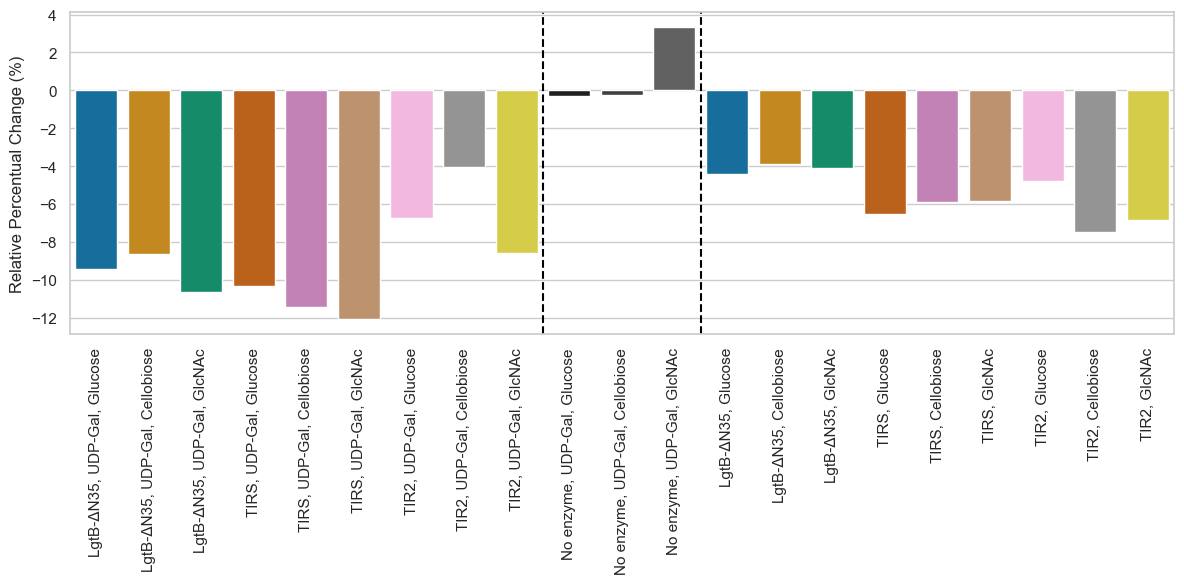

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def process_and_plot():
    # Load the Excel file
    file_path = r'C:\Users\Lenovo\Documents\BT Studies\MASTER PROJECT\Tecans_pHassay.xlsx'
    df = pd.read_excel(file_path, sheet_name="Change", header=None)

    # Define groups with correct row indexing
    groups = {
        "Group 1": (1, 10, 0),  # Rows 1-10, Labels in row 1
        "Group 2": (12, 21, 11), # Rows 12-21, Labels in row 12
        "Group 3": (23, 32, 22)  # Rows 23-32, Labels in row 23
    }

    # Initialize lists
    x_labels = []
    percent_changes = []
    group_assignments = []

    # Iterate through groups
    for group_index, (group_name, (start, end, label_row)) in enumerate(groups.items()):
        measurement_labels = df.iloc[label_row, :].dropna().values  # Extract measurement labels

        for i in range(4):  # Iterate over 4 sets of columns (1-3, 4-6, 7-9, 10-12)
            name_col = i * 3
            before_col = name_col + 1
            after_col = name_col + 2

            if after_col >= df.shape[1]:  # Ensure columns exist
                continue

            sub_df = df.iloc[start:end+1, [name_col, before_col, after_col]].dropna()

            for name in sub_df.iloc[:, 0].unique():
                subset = sub_df[sub_df.iloc[:, 0] == name]
                if len(subset) >= 3:
                    mean_before = subset.iloc[:, 1].mean()
                    mean_after = subset.iloc[:, 2].mean()
                    percent_change = ((mean_after - mean_before) / mean_before) * 100

                    x_labels.append(f"{measurement_labels[i]}, {name}")
                    percent_changes.append(percent_change)
                    group_assignments.append(group_index)

    # Define color palette
    palette = sns.color_palette("colorblind", 10)
    grey_palette = sns.color_palette("gray", len(percent_changes) // 3)  # Greys for Group 2

    # Assign colors with consistent order for Group 1 and Group 3
    color_map = {}  # To store color mappings for consistent ordering
    colors = []
    color_index = 0
    group1_colors = []

    for index, label in zip(group_assignments, x_labels):
        if index == 1:  # Group 2 -> use grey tones
            colors.append(grey_palette.pop(0))
        else:  # Group 1 and 3 -> use the same colorblind palette in the same order
            if index == 0:  # Store colors for Group 1
                color = palette[color_index % len(palette)]
                color_map[label] = color
                group1_colors.append(color)
            else:  # Group 3 should follow the same order as Group 1
                color = group1_colors[color_index % len(group1_colors)]
            colors.append(color)
            color_index += 1

    # Plot results
    sns.set(style="whitegrid")

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=x_labels, y=percent_changes, palette=colors)

    # Add vertical lines to separate groups
    group_boundaries = [9, 12]  # Vertical lines between bar 9 & 10 and 12 & 13
    for boundary in group_boundaries:
        plt.axvline(x=boundary - 0.5, color='black', linestyle='--')

    plt.xticks(rotation=90)
    plt.ylabel("Relative Percentual Change (%)")
    plt.tight_layout()
    plt.show()

# Run the function
process_and_plot()



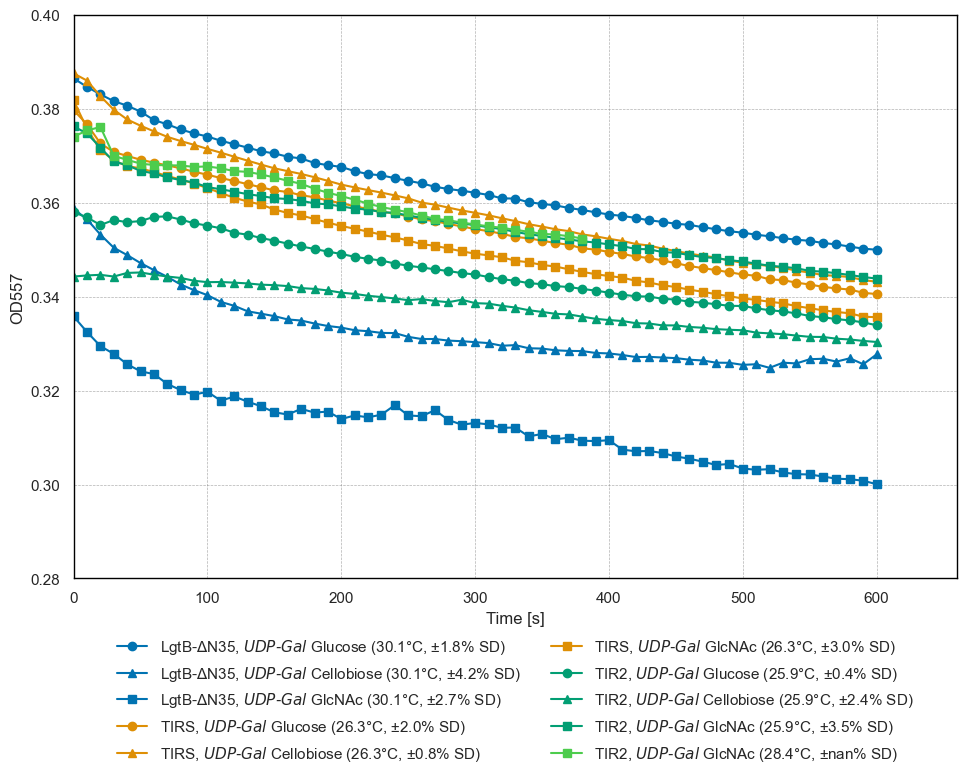

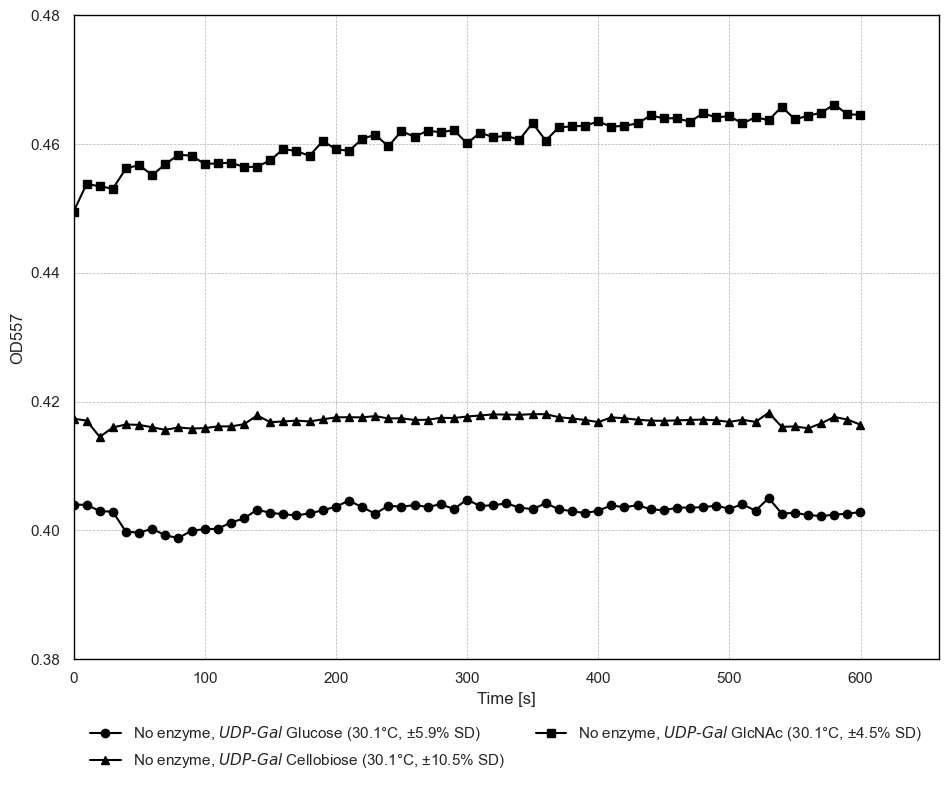

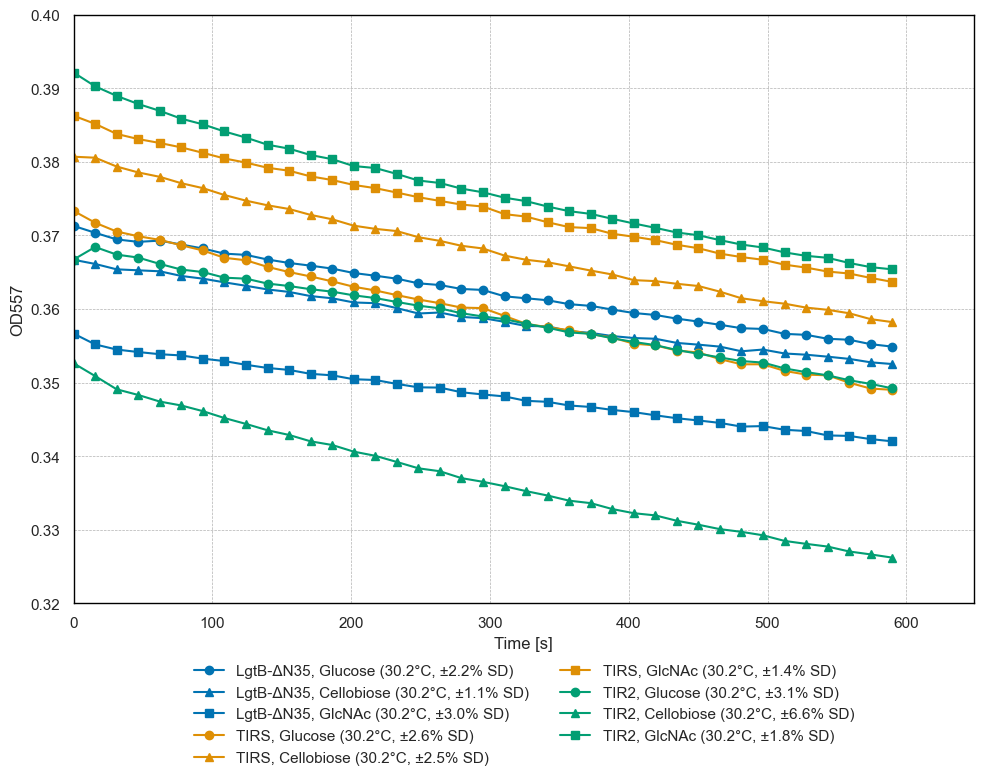

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the Excel file
file_path = r'C:\Users\Lenovo\Documents\BT Studies\MASTER PROJECT\Tecans_pHassay.xlsx'
xls = pd.ExcelFile(file_path)

# Use Seaborn colorblind palette
palette = sns.color_palette("colorblind", 10)

# Define markers for substrates
substrate_markers = {
    "Glucose": "o",      # Circle
    "Cellobiose": "^",   # Triangle
    "GlcNAc": "s"        # Square
}

# Define y-axis limits for specific sheets
y_axis_limits = {
    "Activity": (0.28, 0.40),
    "No enzyme": (0.38, 0.48),
    "Blanks": (0.32, 0.40)
}

# Iterate through sheets
for sheet_name in xls.sheet_names:
    if sheet_name not in ["Activity", "Blanks", "No enzyme"]:
        continue  # Skip irrelevant sheets

    df = xls.parse(sheet_name, header=None)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("OD557")

    # Set white background
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")

    # Enable grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.6)

    # Set black border around plot
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    color_counter = 0
    custom_colors = palette.copy()

    if sheet_name == "No enzyme":
        custom_colors = ['black'] * len(custom_colors)

    if sheet_name == "Activity" and len(custom_colors) > 3:
        custom_colors[3] = (0.3, 0.8, 0.3)

    legend_handles = []
    legend_labels = []

    i = 0
    while i < len(df):
        if pd.notna(df.iloc[i, 0]) and df.iloc[i, 0] not in ["Cycle Nr.", "Time [s]", "Temp. [°C]"]:
            enzyme = df.iloc[i, 0]
            enzyme_color = custom_colors[color_counter % len(custom_colors)]
            color_counter += 1

            time_values = df.iloc[i + 2, 1:].astype(float).values
            temp_mean = df.iloc[i + 3, 1:].astype(float).mean()
            i += 4

            while i < len(df) and pd.notna(df.iloc[i, 0]):
                substrate = df.iloc[i, 0]
                values = []

                while i < len(df) and df.iloc[i, 0] == substrate:
                    values.append(df.iloc[i, 1:].astype(float).values)
                    i += 1

                values = np.asarray(values, dtype=float)
                mean_values = values.mean(axis=0)
                std_values = values.std(axis=0)
                std_percentage = (std_values / mean_values) * 100
                avg_std_percentage = std_percentage.mean()

                label = f"{enzyme} {substrate} ({temp_mean:.1f}°C, ±{avg_std_percentage:.1f}% SD)"
                label = label.replace("UDP-Gal", r"$\it{UDP\text{-}Gal}$")

                line, = ax.plot(
                    time_values,
                    mean_values,
                    color=enzyme_color,
                    marker=substrate_markers.get(substrate, "x"),
                    linestyle='-',
                    label=label
                )
                legend_handles.append(line)
                legend_labels.append(label)
        else:
            i += 1

    if sheet_name == "Activity":
        ax.set_xlim(left=0, right=600 * 1.1)
    else:
        ax.set_xlim(left=0, right=max(time_values) * 1.1)

    if sheet_name in y_axis_limits:
        ax.set_ylim(y_axis_limits[sheet_name])

    # Legend with italic formatting, no frame
    ax.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()


